In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# August 2024
# License: MIT

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator, ClassifierMixin

np.random.seed(42)

In [3]:
class HardMarginSVM(BaseEstimator, ClassifierMixin):      
    def fit(self, X, y):        
        n_samples = X.shape[0]
        y_vec = y.reshape(-1, 1)  # Reshape y into a column vector
    
        # Quadratic programming problem formulation
        P = matrix((y_vec @ y_vec.T) * (X @ X.T))  # The quadratic term of the objective
        q = matrix(-np.ones(n_samples))            # The linear term of the objective
        G = matrix(-np.eye(n_samples))             # Inequality constraints: -alpha <= 0
        h = matrix(np.zeros(n_samples))            # Bounds for the inequality constraints
        A = matrix(y_vec.T, (1, n_samples), 'd')   # The equality constraint
        b = matrix(0.0)                            # Value of the equality constraint

        # Solve the quadratic programming problem
        solution = solvers.qp(P, q, G, h, A, b)

        # Extract the Lagrange multipliers from the solution
        alphas = np.array(solution['x']).flatten() 

        # Identify the support vectors (nonzero Lagrange multipliers)
        support_vector_indices = alphas > 1e-5  

        # Save the nonzero multipliers, support vectors, and their labels
        self.alphas_ = alphas[support_vector_indices]
        self.support_vectors_ = X[support_vector_indices]
        self.support_vector_labels_ = y[support_vector_indices]

        # Compute the weight vector and bias of the separating hyperplane
        self.coef_ = (self.alphas_ * self.support_vector_labels_) @ self.support_vectors_
        self.intercept_ = np.mean(
            self.support_vector_labels_ - self.support_vectors_ @ self.coef_
        )          
        return self

    def decision_function(self, X):
        """Compute the raw scores (distances from the decision boundary)"""
        return X @ self.coef_ + self.intercept_

    def predict(self, X):
        """Classify data points based on the sign of the decision function"""
        return np.sign(self.decision_function(X))

In [4]:
from sklearn.datasets import load_iris


iris = load_iris()
X = iris.data[:, :2]  # Take only the first two features
y = iris.target
class_labels = iris.target_names

# Filter for setosa and versicolor flowers (labels 0 and 1)
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

# Convert labels from {0, 1} to {-1, 1}
y = 2 * y - 1  

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
model = HardMarginSVM()
model.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.4047e+01 -3.0811e+01  2e+02  1e+01  2e+00
 1: -2.6255e+01 -3.1831e+01  9e+01  5e+00  7e-01
 2: -4.8755e+01 -4.6481e+01  8e+01  4e+00  5e-01
 3: -4.3936e+01 -4.5169e+01  7e+01  2e+00  3e-01
 4: -3.6054e+01 -3.5550e+01  7e+00  2e-01  3e-02
 5: -3.3810e+01 -3.3813e+01  7e-02  2e-03  3e-04
 6: -3.3795e+01 -3.3795e+01  7e-04  2e-05  3e-06
 7: -3.3795e+01 -3.3795e+01  7e-06  2e-07  3e-08
 8: -3.3795e+01 -3.3795e+01  7e-08  2e-09  3e-10
Optimal solution found.


HardMarginSVM()

In [7]:
print(f'Training accuracy: {model.score(X_train, y_train):.4f}')
print(f'Test accuracy: {model.score(X_test, y_test):.4f}')

Training accuracy: 1.0000
Test accuracy: 1.0000


In [8]:
def plot_svm_decision_boundary(model, X, y, feature_names=None, class_labels=None, ax=None, legend=True):
    """Plot the decision boundary, margin, and support vectors of an SVM classifier."""
    if feature_names is None:
        feature_names = ['$x_1$', '$x_2$']
    if class_labels is None:
        class_labels = ['Class 0', 'Class 1']
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='red', s=50, edgecolors='k', label=class_labels[0])
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', s=50, edgecolors='k', label=class_labels[1])
    
    # Create grid to evaluate model
    x0, x1 = np.meshgrid(
        np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 250),
        np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 250)
    )
    grid = np.c_[x0.ravel(), x1.ravel()]

    # Plot the decision boundary and margins
    y_decision = model.decision_function(grid).reshape(x0.shape)
    ax.contour(x0, x1, y_decision, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')

    # Fill the class areas
    y_pred = model.predict(grid).reshape(x0.shape)
    custom_cmap = plt.cm.colors.ListedColormap(['red', 'blue'])
    ax.contourf(x0, x1, y_pred, alpha=0.3, cmap=custom_cmap)
    
    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=150,
                   facecolors='none', edgecolors='black', label='support vectors') 

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    if legend:
        ax.legend()

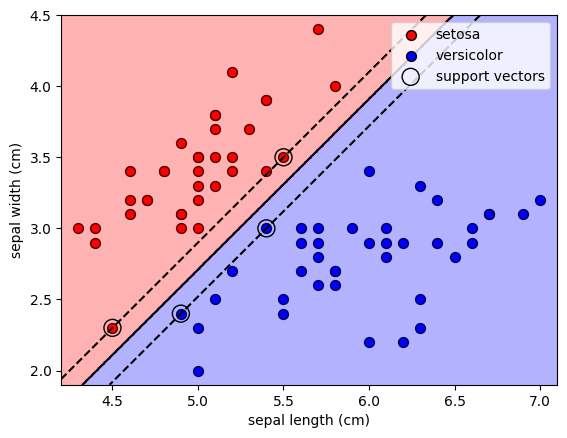

In [9]:
y_train_bin = np.where(y_train == -1, 0, y_train)  # Convert labels from -1/1 to 0/1
plot_svm_decision_boundary(model, X_train, y_train_bin, iris.feature_names[:2], class_labels)
plt.savefig('figures/hard_margin_svm.pdf')